# FX Option 2 Trade Comparison

This notebook allows the user to set up different types of FXOption with different styles (Digital or American for example), and show impact on valuation over spot and time. The notebook is designed more for testing of different combinations of products.

**Table of Contents:**
- [1. Create Portfolio](#1.-Create-Portfolio)
- [2. Create Instrument](#2.-Create-Instrument)
- [3. Upsert Transactions](#3.-Upsert-Transactions)
- [4. Upsert FX Market Data](#4.-Upsert-FX-Market-Data)
- [5. Create Configuration Recipe](#5.-Create-Configuration-Recipe)
- [6. Valuation](#6.-Valuation)
- [7. Spot Ladder](#7.-Spot-Ladder)


In [93]:
# Import generic non-LUSID packages
import os
import pandas as pd
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import json
import pytz
import numpy as np
from IPython.core.display import HTML

# Import key modules from the LUSID package
import lusid
import lusid.models as lm
import lusid.api as la
from lusid.utilities import ApiClientFactory
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

# Import key functions from Lusid-Python-Tools and other packages
from lusidjam import RefreshingToken

# Set DataFrame display formats
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.4f}".format
display(HTML("<style>.container { width:90% !important; }</style>"))

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

# For running the notebook locally
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

# Authenticate our user and create our API client
api_factory = ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path)

print ('LUSID Environment Initialised')
print ('LUSID API Version :', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

LUSID Environment Initialised
LUSID API Version : 0.6.9978.0


In [94]:
# Set required APIs
portfolio_api = api_factory.build(lusid.api.PortfoliosApi)
transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
instruments_api = api_factory.build(lusid.api.InstrumentsApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)
complex_market_data_api = api_factory.build(lusid.api.ComplexMarketDataApi)
aggregation_api = api_factory.build(lusid.api.AggregationApi)

In [95]:
# Define scopes
scope = "ibor-opt"
market_data_scope = "ibor-opt"
market_supplier = "Lusid"

# 1. Create Portfolio

We begin by creating a portfolio that will contain the FX option instruments that we will be looking to price. We will be grouping the OTC deals using a sub-holding key, this will then keep the transactions associated with a particular deal (and not instrument which is the default LUSID behaviour) linked.

In [96]:
# Obtain the LUSID Property Definition API
property_definition_api = api_factory.build(la.PropertyDefinitionsApi)

# Create a property definition for the SHK in the 'Transaction' domain, with a unique scope and code
property_definition = lm.CreatePropertyDefinitionRequest(
    domain = "Transaction",
    scope = scope,
    code = "DealId",
    display_name = "Deal ID",
    data_type_id = lm.ResourceId(
        scope = "system",
        code = "string"
    )
)

# Upsert property definition to LUSID
try:
    upsert_property_definition_response = property_definition_api.create_property_definition(
        create_property_definition_request = property_definition
    )
    print(f"Property definition created with the following key: {upsert_property_definition_response.key}")
except lusid.ApiException as e:
    if json.loads(e.body)["name"] == "PropertyAlreadyExists":
            print(f"Property definition with the following key already exists: {property_definition.domain}/{property_definition.scope}/{property_definition.code}")

# Capture SHK 3-stage property key for future use
sub_holding_key = f"{property_definition.domain}/{property_definition.scope}/{property_definition.code}"

Property definition with the following key already exists: Transaction/ibor-opt/DealId


In [97]:
def create_portfolio (portfolio_name):
   
    try:
        transaction_portfolios_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
                display_name=portfolio_name,
                code=portfolio_name,
                base_currency="EUR",
                created="2010-01-01",
                # Register the SHK property with the portfolio
                sub_holding_keys = [sub_holding_key],
                instrument_scopes=[scope]
            ),
        )

    except lusid.ApiException as e:
        print(e.body) 

In [98]:
portfolio_code_opt1 = "fxOption1"
portfolio_code_opt2 = "fxOption2"

create_portfolio(portfolio_code_opt1)
create_portfolio(portfolio_code_opt2)

# 2. Create Instrument

We create a helper function to create and upsert the fxOption instrument into LUCID, this will reference the SDK models to populate the required parameters for creating an FX Option. We then populate the instrument variables, and make a call to persist the instrument in LUSID.

In [99]:
# Define function that creates an FX option

def create_fx_option(strike, dom_ccy, fgn_ccy, start_date, maturity_date, settlement_date, is_call, is_fx_delivery = True, is_payoff_digital = False, exercise_type = "European"):
    
    return lm.FxOption(
        strike = strike,
        dom_ccy = dom_ccy,
        fgn_ccy = fgn_ccy,
        start_date = start_date,
        option_maturity_date = maturity_date,
        option_settlement_date = settlement_date,
        is_call_not_put = is_call,
        is_delivery_not_cash = is_fx_delivery,
        is_payoff_digital = is_payoff_digital,
        instrument_type = "FxOption",
        dom_amount = 1,
        exercise_type = exercise_type
    )

# Define a function to upsert instrument
def upsert_instrument_to_lusid(scope, instrument_definition, name, identifier, identifier_type):
        return instruments_api.upsert_instruments(
            request_body={
                identifier: lm.InstrumentDefinition(
                    name=name,
                    identifiers={
                        identifier_type: lm.InstrumentIdValue(value=identifier)
                    },
                    definition=instrument_definition,
                )
            },
            scope = scope
        )

## 2.1 Create Instruments

All the informaton about the 2 FXOptions are contained in the next 2 cells, including the pricing model so that all of this data is together.

Change this data as you see fit to understand how the different Option types work in LUSID. The table below shows the different model and PayOff Combinations

![Init](img/FXOptionSummary.PNG)

In [100]:
# Set common  trade variables
trade_date = datetime(2021, 1, 20, tzinfo=pytz.utc)
start_date = trade_date
settle_days = 2
units = 1000000
dom_ccy = "EUR"
fgn_ccy = "USD"
strike = 1.2050
premium_currency = "EUR"
identifier_type = "ClientInternal"
valuation_model_opt1 = "BlackScholesDigital"

# Option_1:  Choose your parameters.....
maturity_date = trade_date + timedelta(days = 30)
settlement_date = maturity_date + timedelta(days = 2)

option_1_name = "EUR/USD FX Option " + maturity_date.strftime("%m/%d/%Y")  + " " + str(strike)
option_1_identifier = "EURUSDOption1Demo"

# Create the Instrument
option_1_definition = create_fx_option(
    strike = strike,
    dom_ccy = dom_ccy,
    fgn_ccy = fgn_ccy,
    start_date = start_date,
    maturity_date = maturity_date,
    settlement_date = settlement_date,
    is_call = True,
    is_fx_delivery = True,
    is_payoff_digital = True,
    exercise_type = "European"
)

# Upsert the instrument
response = upsert_instrument_to_lusid(scope, option_1_definition, option_1_name, option_1_identifier, identifier_type)

if response.failed == {}:
    luid = response.values[option_1_identifier].lusid_instrument_id
    print(f"Instrument successfully loaded into LUSID. {luid} : {option_1_identifier}")
else:
    print(f"Failures occurred during instrument upsertion, {response.failed}")

Instrument successfully loaded into LUSID. LUID_00003FUF : EURUSDOption1Demo


In [120]:
#Option_2: Choose your parameters.....
maturity_date = trade_date + timedelta(days = 30)
settlement_date = maturity_date + timedelta(days = 2)

option_2_name = "EUR/USD FX Option " + maturity_date.strftime("%m/%d/%Y")  + " " + str(strike)
option_2_identifier = "EURUSDOption2Demo"
valuation_model_opt2 = "BjerksundStensland1993"

# Create the Instrument
option_2_definition = create_fx_option(
    strike = strike,
    dom_ccy = dom_ccy,
    fgn_ccy = fgn_ccy,
    start_date = start_date,
    maturity_date = maturity_date,
    settlement_date = settlement_date,
    is_call = False,
    is_fx_delivery = True,
    is_payoff_digital = False,
    exercise_type = "American"
)

# Upsert the instrument
response = upsert_instrument_to_lusid(scope, option_2_definition, option_2_name, option_2_identifier, identifier_type)

if response.failed == {}:
    luid = response.values[option_2_identifier].lusid_instrument_id
    print(f"Instrument successfully loaded into LUSID. {luid} : {option_2_identifier}")
else:
    print(f"Failures occurred during instrument upsertion, {response.failed}")

Instrument successfully loaded into LUSID. LUID_00003FUG : EURUSDOption2Demo


# 3. Upsert Transactions

Having created the portfolio and the Instruments, we add a Buy transaction against the option to create a position with the costs incurred representing the premium for the option.

In [102]:
# Book a Buy transaction against Option_1. The option here has a premium of 0.02 / notional.
premium = 0.02
option_1_version = 1
deal_1_id = "TXN001"

opt_txn = lm.TransactionRequest(
    transaction_id= deal_1_id + "." + str(option_1_version),
    type="Buy",
    instrument_identifiers={"Instrument/default/ClientInternal": option_1_identifier},
    transaction_date=trade_date,
    settlement_date=trade_date + timedelta(days = settle_days),
    units=units,
    transaction_price=lm.TransactionPrice(price=premium,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=premium*units,currency=premium_currency),
    exchange_rate=1,
    transaction_currency=premium_currency,
    # Assign the SHK property to each transaction so it is loaded against each deal_id
    properties = {
        f"{sub_holding_key}": lm.PerpetualProperty(
            key = f"{sub_holding_key}",
            value = lm.PropertyValue(label_value = deal_1_id)
        )
    },
)

response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                    code=portfolio_code_opt1,
                                                    transaction_request=[opt_txn])

print(f"Transaction successfully updated at time: {response.version.as_at_date}")

option_1_version+=1

Transaction successfully updated at time: 2022-09-16 13:14:07.923511+00:00


In [103]:
# Book a Buy transaction against Option_1. The option here has a premium of 0.02 / notional (same as the above option as we want to compare the pay offs)
premium = 0.02
option_2_version = 1
deal_2_id = "TXN002"

opt_txn = lm.TransactionRequest(
    transaction_id= deal_2_id + "." + str(option_2_version),
    type="Buy",
    instrument_identifiers={"Instrument/default/ClientInternal": option_2_identifier},
    transaction_date=trade_date,
    settlement_date=trade_date + timedelta(days = settle_days),
    units=units,
    transaction_price=lm.TransactionPrice(price=premium,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=premium*units,currency=premium_currency),
    exchange_rate=1,
    transaction_currency=premium_currency,
    # Assign the SHK property to each transaction so it is loaded against each deal_id
    properties = {
        f"{sub_holding_key}": lm.PerpetualProperty(
            key = f"{sub_holding_key}",
            value = lm.PropertyValue(label_value = deal_2_id)
        )
    },
)

response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                    code=portfolio_code_opt2,
                                                    transaction_request=[opt_txn])

print(f"Transaction successfully updated at time: {response.version.as_at_date}")

option_2_version+=1

Transaction successfully updated at time: 2022-09-16 13:14:08.280222+00:00


# 4. Upsert FX Market Data

Next we will be loading the required marked data into the quotes store. In this particular example to value an option, we will be using the standard Black-Scholes pricing model. This model requires the following data:
1. EUR/USD Spot Rates - this is the value of the underlying of the option
2. EUR and USD discount curves - these curves are required for 2 things: to calculate the implied fx forward rate; and as the option is expiring and maturing in the future, to discount future cash flows
3. EURUSD volatility surface - the value of an option is closely related to the expected volatility of the underlying over the period of the option

## 4.1 FX Spot Rates

We begin by adding the FX spot rates.

In [104]:
# Read fx spot rates and make datetimes timezone aware
quotes_df = pd.read_csv("data/eurusd_spot.csv")
quotes_df["Date"] = pd.to_datetime(quotes_df["Date"], dayfirst=True)
quotes_df["Date"] = quotes_df["Date"].apply(lambda x: x.replace(tzinfo=pytz.utc))
quotes_df.head()

,Date,Rate,Pair
0,2020-07-13 00:00:00+00:00,1.2215,EUR/USD
1,2020-07-14 00:00:00+00:00,1.2248,EUR/USD
2,2020-07-15 00:00:00+00:00,1.2298,EUR/USD
3,2020-07-16 00:00:00+00:00,1.2327,EUR/USD
4,2020-07-17 00:00:00+00:00,1.2272,EUR/USD


In [105]:
# Create quotes request
instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider=market_supplier,
                    instrument_id=row["Pair"],
                    instrument_id_type="CurrencyPair",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"],
            ),
            metric_value=lm.MetricValue(value=row["Rate"], unit=row["Pair"]),
        )
    for index, row in quotes_df.iterrows()
}

# Upsert quotes into LUSID
response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=instrument_quotes
)

if response.failed == {}:
    print(f"Quotes successfully loaded into LUSID. {len(response.values)} quotes loaded.")
else:
    print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")

Quotes successfully loaded into LUSID. 739 quotes loaded.


## 4.2 EUR & USD Discount curves

Next we will read in the EUR and USD Discount factors and create separate OIS curves.

In [106]:
# Read FX market data - showing first 10 terms
df_market_data = pd.read_csv("data/EURUSD-MarketData.csv")
df_market_data["Days"]= df_market_data["Days"].astype(int)
df_market_data = df_market_data.reset_index()
df_market_data.head(10)

,index,Tenor,Days,EUR-Rates,USD-Rates,EURdf,USDdf,Vol25D,ATM,Vol75D,Strike25D,StrikeATM,Strike75D
0,0,1M,30,0.2200,1.2200,0.9998,0.9990,0.1200,0.1000,0.1100,1.1850,1.2000,1.2150
1,1,2M,60,0.3700,1.3700,0.9994,0.9978,0.1205,0.1010,0.1105,1.1850,1.2000,1.2150
2,2,3M,90,0.5300,1.5300,0.9987,0.9962,0.1210,0.1020,0.1110,1.1850,1.2000,1.2150
3,3,6M,180,0.9500,1.9500,0.9953,0.9904,0.1215,0.1030,0.1115,1.1850,1.2000,1.2150
4,4,1Y,365,1.3000,2.3000,0.9871,0.9773,0.1220,0.1040,0.1120,1.1850,1.2000,1.2150
5,5,18M,547,1.5000,2.5000,0.9778,0.9632,0.1225,0.1050,0.1125,1.1850,1.2000,1.2150
6,6,2Y,730,1.5000,2.5000,0.9705,0.9513,0.1230,0.1060,0.1130,1.1850,1.2000,1.2150
7,7,3Y,1095,1.4300,2.4300,0.9580,0.9297,0.1235,0.1070,0.1135,1.1850,1.2000,1.2150
8,8,4Y,1460,1.3700,2.3700,0.9467,0.9096,0.1240,0.1080,0.1140,1.1850,1.2000,1.2150
9,9,5Y,1825,1.3100,2.3100,0.9366,0.8909,0.1245,0.1090,0.1145,1.1850,1.2000,1.2150


In [107]:
# Set up the OIS curves loader function
def upsert_discount_factors(scope, effective_at, market_asset, dates, dfs):

    complex_market_data = lm.DiscountFactorCurveData(
        base_date=effective_at,
        dates=dates,
        discount_factors = dfs,
        market_data_type="DiscountFactorCurveData"
    )

    # create a unique identifier for our OIS yield curves
    complex_id = lm.ComplexMarketDataId(
        provider=market_supplier,
        price_source = market_supplier,
        effective_at=effective_at,
        market_asset=market_asset,
    )
    
    upsert_request = lm.UpsertComplexMarketDataRequest(
        market_data_id=complex_id, market_data=complex_market_data
    )


    response = complex_market_data_api.upsert_complex_market_data(
        scope=scope, request_body={market_asset: upsert_request}
    )
    
    if response.failed:
        print(f"Failed to upload yield curve {response.failed}")

    print(f"{market_asset} yield curve uploaded into scope={scope}")
    
    return complex_id

In [108]:
# Set up the OIS curves
base_date = trade_date
dates = []
dfs = []

# loading the data for EUR OIS discount curve
for index, row in df_market_data.iterrows():
    dates.append(base_date + timedelta(days=row["Days"]))
    dfs.append(row["EURdf"])

curve_id_EUR = upsert_discount_factors(market_data_scope, base_date, "EUR/EUROIS", dates, dfs)


dates = []
dfs = []

# loading the data for USD OIS discount curve
for index, row in df_market_data.iterrows():
    dates.append(base_date + timedelta(days=row["Days"]))
    dfs.append(row["USDdf"])
    
curve_id_USD = upsert_discount_factors(market_data_scope, base_date, "USD/USDOIS", dates, dfs)

EUR/EUROIS yield curve uploaded into scope=ibor-opt
USD/USDOIS yield curve uploaded into scope=ibor-opt


We can also use the _ComplexMarketDataApi_ to retrieve the data as it's been stored in LUSID. See below for the returned object, and a plot showing both OIS discount curves.

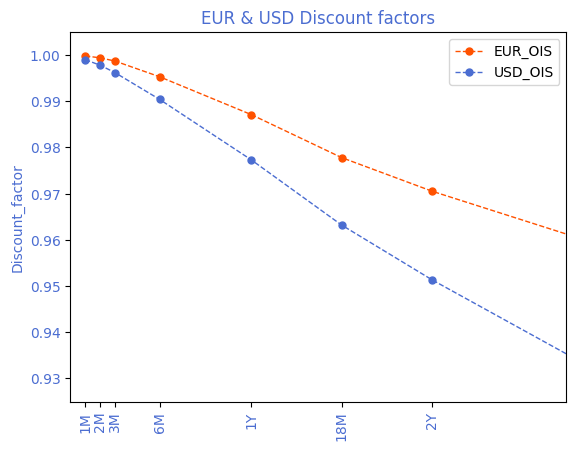

In [109]:
# Retrieve the two curves from LUSID to demonstrate graphically the data we have laoded
EUR_OIS_curve = complex_market_data_api.get_complex_market_data(
    scope=market_data_scope,
    request_body= {"1": curve_id_EUR}
)

USD_OIS_curve = complex_market_data_api.get_complex_market_data(
    scope=market_data_scope,
    request_body= {"1": curve_id_USD}
)

# Get axis data and create plot
plt.plot(df_market_data["Days"],EUR_OIS_curve.values["1"].discount_factors, color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="EUR_OIS")
plt.plot(df_market_data["Days"],USD_OIS_curve.values["1"].discount_factors, color='#4b6dd1' , marker='o', markersize=5, linestyle='--', linewidth=1, label="USD_OIS")
plt.yticks( color = '#4b6dd1')
plt.xticks(df_market_data["Days"], df_market_data["Tenor"], rotation='vertical', color = '#4b6dd1')
plt.title('EUR & USD Discount factors', color = '#4b6dd1')
plt.ylabel('Discount_factor', color = '#4b6dd1')
plt.xlim([0, 1000]), plt.ylim([.925, 1.005])
plt.legend(loc="upper right")
plt.show()

## 4.3 FX Volatility Surface
Next we will read in our FX Vol surface data, and need to create a set of vanilla option instruments representing the FX Option for each tenor in the market data. The volatility curve is constructed using a set of liquid market instruments for vanilla options with different expiry dates, all with a start date of the current date (in this workbook the base_date). Traders would observe option premium prices in the market, and determine the volatility (by solving using the Black-Scholes formula) to allow the volatility curve to be created. Ordinarily a volatility surface is created with a number (usually 3 or 5) of different in and out of the money options being used at each expiry date, with a 'Smile Model' used to interpolate between these points. LUSID provides a more basic interpolation between the data points currently.

To set up a Vol curve you need to abide by the following constraints in LUSID:
1. The vol surface needs to have at least 2 different strikes at each tenor, these strikes must be consistent across all tenors
2. An instrument representing the vanilla fx option needs to be created for each tenor / strike combination
3. Quotes need to be loaded for all tenor / strike combinations

Below I demonstrate setting up a simple 3 point smile in LUSID - before loading this data into LUSID, lets visualise the data we are loading.

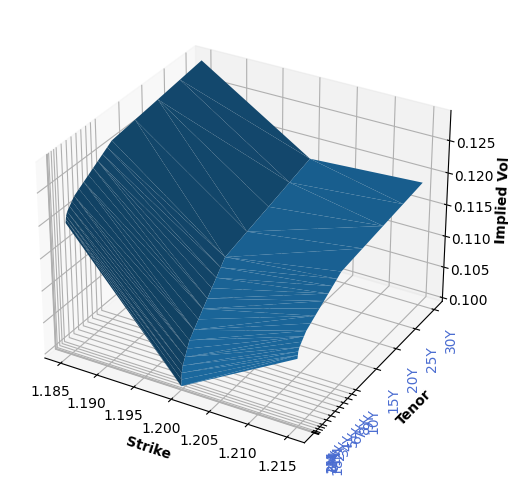

In [110]:
Xs = []
Ys = []
Zs = []

for index, row in df_market_data.iterrows():
    Xs.append(row["Strike25D"])
    Ys.append(row["Days"])
    Zs.append(row["Vol25D"])
    
for index, row in df_market_data.iterrows():
    Xs.append(row["StrikeATM"])
    Ys.append(row["Days"])
    Zs.append(row["ATM"])
    
for index, row in df_market_data.iterrows():
    Xs.append(row["Strike75D"])
    Ys.append(row["Days"])
    Zs.append(row["Vol75D"])
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Strike', fontweight ='bold')
ax.set_ylabel('Tenor', fontweight ='bold')
ax.set_zlabel('Implied Vol', fontweight ='bold')
surf = ax.plot_trisurf(Xs, Ys, Zs, linewidth=0.1)
plt.yticks(df_market_data["Days"], df_market_data["Tenor"], rotation='vertical', color = '#4b6dd1')
plt.show()

### 4.3.1 Create the curve instruments

In this section we create and upsert the curve instruments used in the volatility curve.

In [111]:
def upsert_fxoption_curve_instruments (df_vol_data):

    for index, row in df_vol_data.iterrows():

        option_expiry = base_date + timedelta(days=row["Days"])

        # Create the Instrument
        option_definition = create_fx_option(
            strike = row["Strike"],
            dom_ccy = dom_ccy,
            fgn_ccy = fgn_ccy,
            start_date = base_date,
            maturity_date = option_expiry,
            settlement_date =option_expiry + timedelta(days=2),
            is_call = True,
            is_payoff_digital = False,
            is_fx_delivery = True,
        )

        option_name = "EUR/USD " + " FX Option " + option_expiry.strftime("%m/%d/%Y")
        option_identifier = (f"EURUSDVolCurve{index}:{row['Strike']}")

        curve_map.append({option_name : option_identifier})
        curve_instruments.append(option_definition)

        # Upsert the instrument
        upsert_response = upsert_instrument_to_lusid(scope, option_definition, option_name, option_identifier, identifier_type)
        curve_instruments_id.append(upsert_response.values[option_identifier].lusid_instrument_id)

In [112]:
curve_instruments = []
curve_instruments_id = []
curve_map = []

upsert_fxoption_curve_instruments (df_market_data[["Days", "Strike25D"]].rename(columns={"Strike25D" : "Strike"}))
upsert_fxoption_curve_instruments (df_market_data[["Days", "StrikeATM"]].rename(columns={"StrikeATM" : "Strike"}))
upsert_fxoption_curve_instruments (df_market_data[["Days", "Strike75D"]].rename(columns={"Strike75D" : "Strike"}))

print(f"{len(curve_instruments)} instruments uploaded to create the vol curve")

57 instruments uploaded to create the vol curve


### 4.3.2 Upload Volatility surface

Next we create the volatility surface in LUSID, associating volatility quotes with each of the instruments we have loaded

In [113]:
# Function to load the surface into Lusid
def upsert_fx_vol(scope, effective_at, market_asset, instruments, vols_low_strike, vols_atm, vols_high_strike):

    market_data_id = lm.ComplexMarketDataId(
        provider=market_supplier,
        price_source="Lusid",
        effective_at=effective_at,
        market_asset=market_asset,
    )
    
    quotes = []
    
    for vol in vols_low_strike:
        quotes.append(lm.MarketQuote(quote_type="LogNormalVol", value=vol))
        
    for vol in vols_atm:
        quotes.append(lm.MarketQuote(quote_type="LogNormalVol", value=vol))   
                
    for vol in vols_high_strike:
        quotes.append(lm.MarketQuote(quote_type="LogNormalVol", value=vol))   

    fx_vol_surface_data = lm.FxVolSurfaceData(
        base_date=effective_at,
        instruments=instruments,
        quotes=quotes,
        market_data_type="FxVolSurfaceData"
    )  
    
    response = complex_market_data_api.upsert_complex_market_data(
        scope=scope,
        request_body={
            market_asset: lm.UpsertComplexMarketDataRequest(
                market_data_id=market_data_id, market_data=fx_vol_surface_data
            )
        },
    )
    
    if len(response.failed) == 0:
        print(f"Quote successfully loaded into LUSID. {len(response.values)} quotes loaded.")

    else:
        print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")
        
    return market_data_id

In [114]:
# Actual load of the data into LUSID
EURUSD_vol_curve_id = upsert_fx_vol(market_data_scope, base_date, "EUR/USD/LN", curve_instruments, df_market_data["Vol25D"], df_market_data["ATM"], df_market_data["Vol75D"])

Quote successfully loaded into LUSID. 1 quotes loaded.


# 5. Create Configuration Recipe

In order to run a valuation, LUSID will require a recipe that drives how a valuation will be conducted. The below recipe defines what model and market data to use in this context.


In [115]:
def create_configuration_recipe(recipe_code, model_name):
    # Populate recipe parameters
    configuration_recipe = lm.ConfigurationRecipe(
        scope=market_data_scope,
        code=recipe_code,
        market=lm.MarketContext(
            market_rules=[
                lm.MarketDataKeyRule(
                        key="FX.CurrencyPair.*",
                        supplier=market_supplier,
                        data_scope=market_data_scope,
                        quote_type="Rate",
                        field="mid",
                        quote_interval="100D"
                    ),
                lm.MarketDataKeyRule(
                    key="FXVol.*.*.*",
                    supplier=market_supplier,
                    data_scope=market_data_scope,
                    price_source=market_supplier,
                    quote_type="Price",
                    field="mid",
                    quote_interval="100D",
                ),
                lm.MarketDataKeyRule(
                    key="Rates.*.*",
                    supplier=market_supplier,
                    data_scope=market_data_scope,
                    price_source=market_supplier,
                    quote_type="Price",
                    field="mid",
                    quote_interval="100D",
                ),
            ],
            options=lm.MarketOptions(
                default_scope = market_data_scope,
                attempt_to_infer_missing_fx=True
            ),
        ),
        pricing=lm.PricingContext(
            model_rules=[
                lm.VendorModelRule(
                    supplier="Lusid",
                    model_name=model_name,
                    instrument_type="FXOption",
                    parameters="{}",
                )
            ],
            options = lm.PricingOptions(
                allow_partially_successful_evaluation = True
            )
        ),
    )

    response = configuration_recipe_api.upsert_configuration_recipe(
        upsert_recipe_request=lm.UpsertRecipeRequest(
            configuration_recipe=configuration_recipe
        )
    )

    print(f"Configuration recipe loaded into LUSID at time {response.value}.")

In [121]:
# Set recipe code
recipe_code_opt1 = "Opt1Valuation"
create_configuration_recipe (recipe_code_opt1, valuation_model_opt1)

# Set recipe code
recipe_code_opt2 = "Opt2Valuation"
create_configuration_recipe (recipe_code_opt2, valuation_model_opt2)


Configuration recipe loaded into LUSID at time 2022-09-16 13:15:43.354599+00:00.
Configuration recipe loaded into LUSID at time 2022-09-16 13:15:43.501985+00:00.


# 6. Valuation

Value the portfolio using the Black Scholes model

In [122]:
def run_valuation(date, portfolio_code, recipe_code):

    metrics = [
        lm.AggregateSpec("Instrument/default/Name", "Value"),
        lm.AggregateSpec("Instrument/default/ClientInternal", "Value"),
        lm.AggregateSpec("Holding/Units", "Value"),
        lm.AggregateSpec("Valuation/PV/Amount", "Value"),
        lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"),
        lm.AggregateSpec("Valuation/Delta", "Value"),
        lm.AggregateSpec("Valuation/Risk/SpotDelta", "Value"),      
    ]

    group_by =[]

    valuation_request = lm.ValuationRequest(
        recipe_id=lm.ResourceId(scope=market_data_scope, code=recipe_code),
        metrics=metrics,
        group_by=group_by,
        portfolio_entity_ids=[
            lm.PortfolioEntityId(scope=scope, code=portfolio_code)
        ],
        valuation_schedule=lm.ValuationSchedule(effective_at=date),
    )

    val_data = aggregation_api.get_valuation(valuation_request=valuation_request).data
    
    vals_df = pd.DataFrame(val_data)

    vals_df.rename(
        columns={
            "Instrument/default/Name": "InstrumentName",
            "Instrument/default/ClientInternal": "ClientInternal",
            "Valuation/PvInPortfolioCcy": "Market Value",
            "Valuation/Diagnostics/FxForwardRate": "Forward Rate (Interpolated)",
            "Quotes/FxRate/DomFgn": "FX Spot Rate",
            "Valuation/PnL/Tm1/Pfolio": "PnL (1-day)"
        },
        inplace=True,
    )

    return vals_df

In [123]:
valuation = run_valuation(base_date, portfolio_code_opt1, recipe_code_opt1)
display(valuation)

,Valuation/PV/Amount,InstrumentName,ClientInternal,Holding/Units,Market Value,Valuation/Delta,Valuation/Risk/SpotDelta
0,"159,335.3937",EUR/USD FX Option 02/19/2021 1.205,EURUSDOption1Demo,"1,000,000.0000","159,335.3937",None,None
1,0.0000,EUR/USD FX Option 02/19/2021 1.205,EURUSDOption1Demo,"1,000,000.0000",0.0000,None,None
2,"-20,000.0000",EUR,None,"-20,000.0000","-20,000.0000",None,None


In [124]:
valuation = run_valuation(base_date, portfolio_code_opt2, recipe_code_opt2)
display(valuation)

,Valuation/PV/Amount,InstrumentName,ClientInternal,Holding/Units,Market Value,Valuation/Delta,Valuation/Risk/SpotDelta
0,"37,594.1460",EUR/USD FX Option 02/19/2021 1.205,EURUSDOption2Demo,"1,000,000.0000","37,594.1460",None,None
1,0.0000,EUR/USD FX Option 02/19/2021 1.205,EURUSDOption2Demo,"1,000,000.0000",0.0000,None,None
2,"-20,000.0000",EUR,None,"-20,000.0000","-20,000.0000",None,None


# 7. Spot Ladder

This demonstrates how to produce a spot ladder to show the PV of the options as the underlying (FX Spot) changes. This is a standard report required by any risk manager looking at an option portfolio, and requires the risk engine to change the spot rate and revalue the portfolio multiple times. For the digital options the spot ladder is run at two different valuation dates, showing the effect as the option gets close to expiry. The methodology to do this is as follows:

1. Obtain and store the spot rate on the day we want to value the portfolio (so we can set the spot rate back to what it was originally)


2. Next run a simple loop to generate the spot ladder, in the loop we:

    a. Calculate the spot level on the ladder    
    
    b. Set this spot rate in the quote store in LUSID
    
    c. Run a valuation and store the results
    
    
3. Finally we put the spot rate back to the original value (so that the normal 'market PV' is then obtained by the next user)

In [125]:
# get the base spot rate for the calculation date (23rd-Jan-2021)
calculation_date = datetime(2021, 1, 23, tzinfo=pytz.utc)

quotes = lm.QuoteSeriesId(
    provider=market_supplier,
    instrument_id="EUR/USD",
    instrument_id_type="CurrencyPair",
    quote_type="Rate",
    field="mid")

quotes_response = quotes_api.get_quotes(
    scope = market_data_scope,
    effective_at = calculation_date,
    request_body = {"1" : quotes}
)
                                         
base_spot_rate = quotes_response.values["1"].metric_value.value

In [126]:
# create a function to upsert the spot rate
def upsert_single_quote (spot, calculation_date):
    # Create quotes request
    instrument_quotes = {
            "1" : lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider=market_supplier,
                    instrument_id="EUR/USD",
                    instrument_id_type="CurrencyPair",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=calculation_date,
            ),
            metric_value=lm.MetricValue(value=spot, unit="EUR/USD"),
        )
    }

    # Upsert quotes into LUSID
    response = quotes_api.upsert_quotes(
        scope=market_data_scope, request_body=instrument_quotes
    )

    if response.failed != {}:
        print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")

## 7.1 Spot Ladder Calculation

The next section is the actual calculation of the spot ladder.

In [127]:
# now run the spot ladder
bump = 0.01
spot_ladder_pvs_opt1 = pd.DataFrame()
spot_ladder_pvs_opt2 = pd.DataFrame()

for i in range (-10 , 5):
    rung_spot = base_spot_rate + (i * bump)
    upsert_single_quote (rung_spot, calculation_date)
    valuation = run_valuation(calculation_date, portfolio_code_opt1, recipe_code_opt1)
    valuation["spot_rate"] = rung_spot
    spot_ladder_pvs_opt1 = pd.concat([spot_ladder_pvs_opt1, valuation], axis=0)
    
    valuation = run_valuation(calculation_date, portfolio_code_opt2, recipe_code_opt2)
    valuation["spot_rate"] = rung_spot
    spot_ladder_pvs_opt2 = pd.concat([spot_ladder_pvs_opt2, valuation], axis=0)
    

#tidy up and reset the spot rate
upsert_single_quote (base_spot_rate, calculation_date)

#sum the results for the portfolio (we need to do this as there are multiple results returned for some models incorrectly)
portfolio_results_opt1 = spot_ladder_pvs_opt1.groupby(["spot_rate"])["Market Value"].sum().reset_index()
portfolio_results_opt2 = spot_ladder_pvs_opt2.groupby(["spot_rate"])["Market Value"].sum().reset_index()

Displaying the PV results graphically for the portfolio

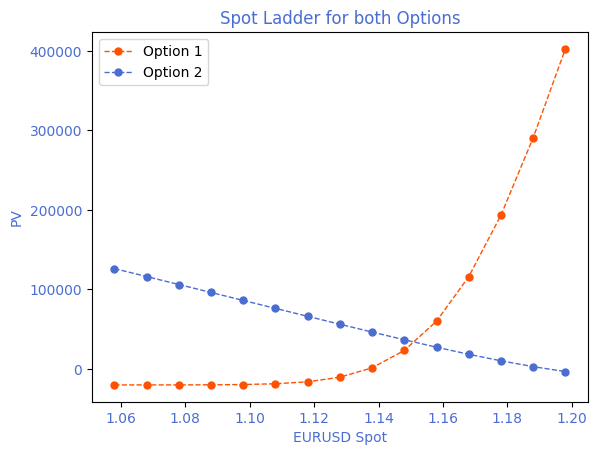

In [128]:
# Get axis data and create plot of the PV
plt.plot(portfolio_results_opt1["spot_rate"],portfolio_results_opt1["Market Value"], color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Option 1")
plt.plot(portfolio_results_opt2["spot_rate"],portfolio_results_opt2["Market Value"], color='#4b6dd1' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Option 2")

plt.title('Spot Ladder for both Options', color = '#4b6dd1')
plt.ylabel('PV', color = '#4b6dd1')
plt.xlabel('EURUSD Spot', color = '#4b6dd1')
plt.xticks(color = '#4b6dd1')
plt.yticks(color = '#4b6dd1')
plt.legend(loc="upper left")
plt.show()

## 7.2 Spot Ladder at a different valuation date

In [129]:
#Now move the calcuation date forward
calculation_date = datetime(2021, 2, 14, tzinfo=pytz.utc)
quotes = lm.QuoteSeriesId(
    provider=market_supplier,
    instrument_id="EUR/USD",
    instrument_id_type="CurrencyPair",
    quote_type="Rate",
    field="mid")

quotes_response = quotes_api.get_quotes(
    scope = market_data_scope,
    effective_at = calculation_date,
    request_body = {"1" : quotes}
)
                                         
base_spot_rate = quotes_response.values["1"].metric_value.value

In [130]:
# now run the spot ladder
bump = 0.01
spot_ladder_pvs_opt1 = pd.DataFrame()
spot_ladder_pvs_opt2 = pd.DataFrame()

for i in range (-7 , 8):
    rung_spot = base_spot_rate + (i * bump)
    upsert_single_quote (rung_spot, calculation_date)
    valuation = run_valuation(calculation_date, portfolio_code_opt1, recipe_code_opt1)
    valuation["spot_rate"] = rung_spot
    spot_ladder_pvs_opt1 = pd.concat([spot_ladder_pvs_opt1, valuation], axis=0)
    
    valuation = run_valuation(calculation_date, portfolio_code_opt2, recipe_code_opt2)
    valuation["spot_rate"] = rung_spot
    spot_ladder_pvs_opt2 = pd.concat([spot_ladder_pvs_opt2, valuation], axis=0)

#tidy up and reset the spot rate
upsert_single_quote (base_spot_rate, calculation_date)
    
#sum the results for the portfolio
portfolio_results_opt1_t1 = spot_ladder_pvs_opt1.groupby(["spot_rate"])["Market Value"].sum().reset_index()
portfolio_results_opt2_t1 = spot_ladder_pvs_opt2.groupby(["spot_rate"])["Market Value"].sum().reset_index()

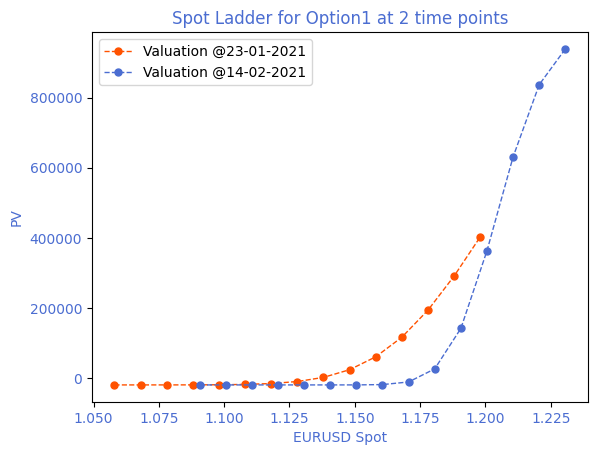

In [131]:
# Get axis data and create plot of the PV
plt.plot(portfolio_results_opt1["spot_rate"],portfolio_results_opt1["Market Value"], color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Valuation @23-01-2021")
plt.plot(portfolio_results_opt1_t1["spot_rate"],portfolio_results_opt1_t1["Market Value"], color='#4b6dd1' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Valuation @14-02-2021")

plt.title('Spot Ladder for Option1 at 2 time points', color = '#4b6dd1')
plt.ylabel('PV', color = '#4b6dd1')
plt.xlabel('EURUSD Spot', color = '#4b6dd1')
plt.xticks(color = '#4b6dd1')
plt.yticks(color = '#4b6dd1')
plt.legend(loc="upper left")
plt.show()

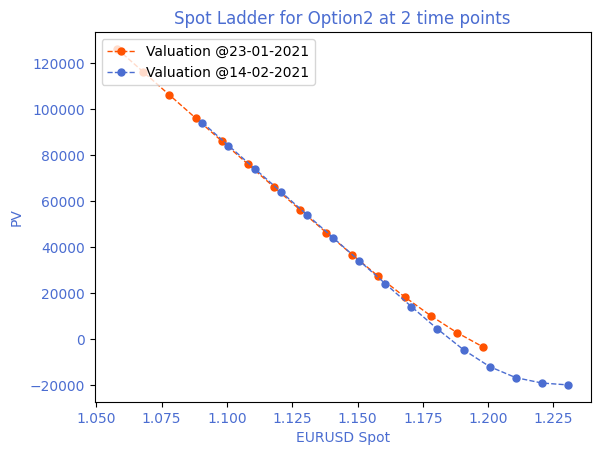

In [132]:
# Get axis data and create plot of the PV
plt.plot(portfolio_results_opt2["spot_rate"],portfolio_results_opt2["Market Value"], color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Valuation @23-01-2021")
plt.plot(portfolio_results_opt2_t1["spot_rate"],portfolio_results_opt2_t1["Market Value"], color='#4b6dd1' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Valuation @14-02-2021")

plt.title('Spot Ladder for Option2 at 2 time points', color = '#4b6dd1')
plt.ylabel('PV', color = '#4b6dd1')
plt.xlabel('EURUSD Spot', color = '#4b6dd1')
plt.xticks(color = '#4b6dd1')
plt.yticks(color = '#4b6dd1')
plt.legend(loc="upper left")
plt.show()

# 8. Check upsertable cashflows

## 8.1 Option 1 

In [133]:
# get valuation at expiry - NOTE there is a bug such that the trade can not be valued intrinsically on the expiry date for American and Digital Options (hence using 29 rather 30 days)
valuation = run_valuation(trade_date + timedelta(days = 29), portfolio_code_opt1, recipe_code_opt1)
display(valuation)

,Valuation/PV/Amount,InstrumentName,ClientInternal,Holding/Units,Market Value,Valuation/Delta,Valuation/Risk/SpotDelta
0,0.0000,EUR/USD FX Option 02/19/2021 1.205,EURUSDOption1Demo,"1,000,000.0000",0.0000,None,None
1,0.0000,EUR/USD FX Option 02/19/2021 1.205,EURUSDOption1Demo,"1,000,000.0000",0.0000,None,None
2,"-20,000.0000",EUR,None,"-20,000.0000","-20,000.0000",None,None


In [134]:
option_exercise_date = datetime(2021, 2, 19, tzinfo=pytz.utc)
# Getting the cashflows as a result of Option_1 exercising.
exercise_cash_flows = transaction_portfolios_api.get_upsertable_portfolio_cash_flows(
    scope=scope,
    code=portfolio_code_opt1,
    effective_at=option_exercise_date,
    window_start=option_exercise_date,
    window_end=option_exercise_date + timedelta(days=2),
    recipe_id_scope=scope,
    recipe_id_code=recipe_code_opt1
)

# we create a dataframe out of the cash flows table
cash_flow_table = lusid_response_to_data_frame(exercise_cash_flows)
cash_flow_table

,transaction_id,type,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_scope,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,total_consideration.amount,total_consideration.currency,exchange_rate,transaction_currency,properties.Transaction/ibor-opt/DealId.key,properties.Transaction/ibor-opt/DealId.value.label_value,source,entry_date_time,transaction_status
0,TXN001.1-LUID_00003FUF-20210221-Principal-EUR-...,CashFlow,LUID_00003FUF,ibor-opt,LUID_00003FUF,2021-02-21 00:00:00+00:00,2021-02-21 00:00:00+00:00,"1,000,000.0000",1.0000,Price,"1,000,000.0000",EUR,1.0000,EUR,Transaction/ibor-opt/DealId,TXN001,default,0001-01-01 00:00:00+00:00,Active


## 8.2 Option 2 

In [135]:
# get valuation at expiry - NOTE there is a bug such that the trade can not be valued intrinsically on the expiry date for American and Digital Options (hence using 29 rather 30 days)
valuation = run_valuation(trade_date + timedelta(days = 29), portfolio_code_opt2, recipe_code_opt2)
display(valuation)

,Valuation/PV/Amount,InstrumentName,ClientInternal,Holding/Units,Market Value,Valuation/Delta,Valuation/Risk/SpotDelta
0,"48,269.1357",EUR/USD FX Option 02/19/2021 1.205,EURUSDOption2Demo,"1,000,000.0000","48,269.1357",None,None
1,0.0000,EUR/USD FX Option 02/19/2021 1.205,EURUSDOption2Demo,"1,000,000.0000",0.0000,None,None
2,"-20,000.0000",EUR,None,"-20,000.0000","-20,000.0000",None,None


In [136]:
option_exercise_date = datetime(2021, 2, 19, tzinfo=pytz.utc)
# Getting the cashflows as a result of Option_1 exercising.
exercise_cash_flows = transaction_portfolios_api.get_upsertable_portfolio_cash_flows(
    scope=scope,
    code=portfolio_code_opt2,
    effective_at=option_exercise_date,
    window_start=option_exercise_date,
    window_end=option_exercise_date + timedelta(days=2),
    recipe_id_scope=scope,
    recipe_id_code=recipe_code_opt2
)

# we create a dataframe out of the cash flows table
cash_flow_table = lusid_response_to_data_frame(exercise_cash_flows)
cash_flow_table

,transaction_id,type,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_scope,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,total_consideration.amount,total_consideration.currency,exchange_rate,transaction_currency,properties.Transaction/ibor-opt/DealId.key,properties.Transaction/ibor-opt/DealId.value.label_value,source,entry_date_time,transaction_status
0,TXN002.1-LUID_00003FUG-20210221-Principal-EUR-Pay,CashFlow,LUID_00003FUG,ibor-opt,LUID_00003FUG,2021-02-21 00:00:00+00:00,2021-02-21 00:00:00+00:00,"-1,000,000.0000",1.0000,Price,"-1,000,000.0000",EUR,1.0000,EUR,Transaction/ibor-opt/DealId,TXN002,default,0001-01-01 00:00:00+00:00,Active
1,TXN002.1-LUID_00003FUG-20210221-Principal-USD-...,CashFlow,LUID_00003FUG,ibor-opt,LUID_00003FUG,2021-02-21 00:00:00+00:00,2021-02-21 00:00:00+00:00,"1,205,000.0000",1.0000,Price,"1,205,000.0000",USD,1.0000,USD,Transaction/ibor-opt/DealId,TXN002,default,0001-01-01 00:00:00+00:00,Active


In [137]:
quotes = lm.QuoteSeriesId(
    provider=market_supplier,
    instrument_id="EUR/USD",
    instrument_id_type="CurrencyPair",
    quote_type="Rate",
    field="mid")

quotes_response = quotes_api.get_quotes(
    scope = market_data_scope,
    effective_at = option_exercise_date,
    request_body = {"1" : quotes}
)
                                         
spot_rate = quotes_response.values["1"].metric_value.value
print(f"Spot rate at expiry: {spot_rate}")

Spot rate at expiry: 1.1587
